# Plot figure 2

In [1]:
import sys
sys.path.insert(1, '../src')
from utils import getBad

import pandas as pd
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

In [2]:
colors = {'normal': '#4daf4a', 'bad': '#e41a1c', 'q': '#f9ba17'}

In [3]:
jpub_count = pd.read_csv('../data/figure_2/EditorJournalPub.csv', sep='\t',
                    usecols=['EditorId','IssnId','BeAvg','AfAvg'],
                    dtype={'EditorId':int,'IssnId':int,'BeAvg':float,'AfAvg':float})
jpub_count.shape

(9971, 4)

In [4]:
normal = pd.read_csv('../data/figure_2/NormalEditors.csv',sep='\t',dtype={'EditorId':int,'IssnId':int})
questionable = pd.read_csv('../data/figure_2/QuestionableEditors.csv',sep='\t',dtype={'EditorId':int,'IssnId':int})
bad_apples = pd.read_csv('../data/figure_2/SuspiciousEditors.csv',sep='\t',dtype={'EditorId':int,'IssnId':int})

normal.shape, questionable.shape, bad_apples.shape

((9325, 2), (646, 2), (153, 2))

In [5]:
jpub_count.head()

,BeAvg,AfAvg,EditorId,IssnId
0,0.700000,0.6,8,8
1,0.571429,0.1,162,8
2,0.100000,0.1,391,8
3,0.600000,0.7,751,8
4,0.333333,0.3,1013,8


## a

In [6]:
print(jpub_count.shape)

to_plot= jpub_count.assign(Before_log = jpub_count.BeAvg.apply(np.log10))
to_plot= to_plot.assign(After_log = to_plot.AfAvg.apply(np.log10))

# for the 0 values, place them at -1.2 and -1.1 on the figure resplectively
to_plot = to_plot.assign(Before_log = to_plot.Before_log.apply(lambda x: -1.1 if x == -np.inf else x))
to_plot = to_plot.assign(After_log = to_plot.After_log.apply(lambda x: -1.2 if x == -np.inf else x))

scatter_q = questionable.merge(to_plot, on=['EditorId','IssnId'])
scatter_normal = normal.merge(to_plot, on=['EditorId','IssnId'])
scatter_bad = bad_apples.merge(to_plot, on=['EditorId','IssnId'])

print(scatter_normal.shape, scatter_q.shape, scatter_bad.shape)

(9971, 4)
(9325, 6) (646, 6) (153, 6)


[-1.1, -1.0, -0.6989700043360187, -0.3010299956639812, 0.0, 0.3010299956639812, 0.6989700043360189, 1.0]
CPU times: user 404 ms, sys: 20.1 ms, total: 424 ms
Wall time: 523 ms


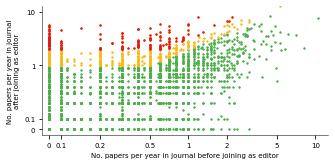

In [7]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(13*cm, 6*cm))

ax = plt.gca()

ax.scatter(x=scatter_normal.Before_log, y=scatter_normal.After_log, c=colors['normal'],
           label = 'Normal editors', s=2)
ax.scatter(x=scatter_q.Before_log, y=scatter_q.After_log, c=colors['q'],
           label = 'Questionable editors', s=2)
ax.scatter(x=scatter_bad.Before_log, y=scatter_bad.After_log, c=colors['bad'],
           label = 'Suspicious editors', s=2)
ax.set_xlabel(r"No. papers per year in journal before joining as editor") #$\bf{before}$
ax.set_ylabel("No. papers per year in journal\n" + r"after joining as editor") # $\bf{after}$

xlabels = ['0']
xlabels.extend([0.1, 0.2, 0.5, 1, 2, 5, 10])
xticks = [-1.1]
xticks.extend(np.log10(x) for x in [0.1, 0.2, 0.5, 1, 2, 5, 10])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_xlim(-1.15, 1.1)

print(xticks)

ylabels = ['0']
ylabels.extend([0.1, 1, 10])
yticks = [-1.2]
yticks.extend(np.log10(x) for x in [0.1, 1, 10])
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylim(-1.3, 1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.legend(loc='lower right')

plt.savefig("../figures/fig_2_a.pdf", bbox_inches = 'tight', pad_inches = 0)

## b

In [8]:
def mean_confidence_interval(a, conf=0.95):
    mean, sem, m = np.mean(a), scipy.stats.sem(a), scipy.stats.t.ppf((1+conf)/2., len(a)-1)
    return m*sem

In [9]:
def plotPvalue(ax, x, y, pVal, ytop, lw=0.5, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    
    height = max(y[0], y[1])
    gap = ytop * 0.05
    vlength = ytop * 0.15
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], y[0] + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], y[1] + gap, yPos, color=c, lw=lw)
    
    stars = '***' if pVal < 0.001 else '**' if pVal < 0.01 else '*' if pVal < 0.05 else f'p={round(pVal, 2)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos + offset*ytop, stars, ha='center', color=c)
    
    return yPos

In [10]:
def plotBar(ax, dfs, col='AfterSCPercent', showP = True, delta=0, scale=0.1):
    c =['#4daf4a', '#f9ba17', '#e41a1c']
    means = [df[col].mean() for df in dfs]
    errs = [mean_confidence_interval(df[col].values) for df in dfs]
    
    if showP:
        pVal = scipy.stats.ttest_ind(dfs[0][col], dfs[1][col]).pvalue
        mid = plotPvalue(ax, [1, 2], [means[0]+errs[0], means[1]+errs[1]], pVal, scale)

        pVal = scipy.stats.ttest_ind(dfs[1][col], dfs[2][col]).pvalue
        right = plotPvalue(ax, [2, 3], [mid, means[2]+errs[2]], pVal, scale)

        pVal = scipy.stats.ttest_ind(dfs[0][col], dfs[2][col]).pvalue
        mid = plotPvalue(ax, [1, 3], [mid, right+delta], pVal, scale)
    
    ax.bar([1, 2, 3], means, yerr=errs, color=c, ecolor=c, alpha=0.5, error_kw={'elinewidth':0.5})
    
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Normal', 'Questionable', 'Suspicious'], rotation=45, ha='center')
    
    labels = ax.get_xticklabels()
    for ind in range(3):
        labels[ind].set_color(c[ind])

In [11]:
sc_count = pd.read_csv('../data/figure_2/EditorSelfCitationPercent.csv',sep='\t',
                      usecols=['EditorId','IssnId','AfterSCPercent','BeforeSCPercent'],
                      dtype={'EditorId':int,'IssnId':int,'BeforeSCPercent':float,'AfterSCPercent':float})
print(sc_count.shape)

print(normal.shape, questionable.shape, bad_apples.shape)

normal_sc = sc_count.merge(normal, on=['EditorId','IssnId']).assign(Type='normal\neditors')
q_sc = sc_count.merge(questionable, on=['EditorId','IssnId']).assign(Type='questionable\neditors')
bad_sc = sc_count.merge(bad_apples, on=['EditorId','IssnId']).assign(Type='suspicious\neditors')

(9971, 4)
(9325, 2) (646, 2) (153, 2)


CPU times: user 138 ms, sys: 3.04 ms, total: 141 ms
Wall time: 143 ms


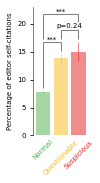

In [12]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(2.5*cm, 6*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()
plotBar(ax, [normal_sc, q_sc, bad_sc], delta=0.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Percentage of editor self-citations')
ax.set_ylim(0, 0.23)
ax.set_yticks([0, 0.05, 0.1, 0.15,0.2])
ax.set_yticklabels(["0", "5", "10", "15", "20"])

ax.tick_params(axis='x', length=0)

plt.savefig("../figures/fig_2_b.pdf",bbox_inches = 'tight', pad_inches = 0)

## c

In [13]:
bad_apples = bad_apples.assign(s=1)
questionable = questionable.assign(q=1)

In [14]:
chief_editors = pd.read_csv('../data/figure_2/EditorsInChief.csv',sep='\t',
                           dtype={'EditorId':int,'IssnId':int,'chief_start':int,'chief_end':int})
print(chief_editors.shape)

chief_editors = chief_editors.merge(bad_apples, on=['EditorId','IssnId'], how='left')
chief_editors = chief_editors.merge(questionable, on=['EditorId','IssnId'], how='left').fillna(0)

chief_editors.shape

(1665, 5)


(1665, 7)

In [15]:
all_count = pd.read_csv('../data/figure_2/JournalSelfCitationCount.csv',sep='\t')

In [16]:
full_range = []
for year in range(chief_editors.chief_start.min(), chief_editors.chief_end.max()+1):
    df = chief_editors[(chief_editors.chief_start <= year) & (chief_editors.chief_end >= year)]
    full_range.append( df.drop(['chief_start','chief_end'], axis=1).assign(Year=year) )
full_range = pd.concat(full_range, ignore_index=True, sort=False)
full_range.shape

(8016, 6)

In [17]:
has_bad = full_range.groupby(['Year','IssnId']).agg({'s':sum, 'q':sum}).reset_index()
has_bad = has_bad.assign(s=has_bad.s>0)
has_bad = has_bad.assign(q=has_bad.q>0)
has_bad = has_bad.assign(n=has_bad.q==0)
assert((has_bad.s <= has_bad.q).all())
has_bad.shape # (4739, 5)

(4739, 5)

In [18]:
print(has_bad.shape, all_count.shape)
to_plot = has_bad.merge(all_count, on=['IssnId','Year'], how='left').fillna(0) # , how='left'
print(to_plot.shape)

(4739, 5) (41525, 5)
(4739, 8)


In [19]:
dfs = [to_plot[to_plot.n==True], to_plot[to_plot.q==True], to_plot[to_plot.s==True]]

In [20]:
dfs[-1]['percent'].mean() + mean_confidence_interval(dfs[-1]['percent'].values) # 0.17725088303536396

0.17725088303536393

CPU times: user 138 ms, sys: 2.95 ms, total: 141 ms
Wall time: 202 ms


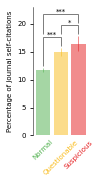

In [21]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(2.5*cm, 6*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()
plotBar(ax, dfs, 'percent')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Percentage of journal self-citations')
ax.set_ylim(0, 0.23)
ax.tick_params(axis='x', length=0)
ax.set_yticks([0, 0.05, 0.1, 0.15,0.2])
ax.set_yticklabels(["0", "5", "10", "15", "20"])

plt.savefig("../figures/main_2_journal_self_cite.pdf",bbox_inches = 'tight', pad_inches = 0)

## e, f

In [22]:
def plotBars(G, axes=None, ylim=10):
    
    if axes is None:
        ax = plt.subplot(1,3,1)
    else:
        ax = axes[0]
    plotDiff(G['n_count'], ax, 'green')
    ax.set_ylim(-ylim*0.1, ylim)
    
    if axes is None:
        ax = plt.subplot(1,3,2)
    else:
        ax = axes[1]
    plotDiff(G['q_count'], ax, 'orange')
    ax.set_ylim(-ylim*0.1, ylim)
    
    if axes is None:
        ax = plt.subplot(1,3,3)
    else:
        ax = axes[2]
    plotDiff(G['s_count'], ax, 'red')
    ax.set_ylim(-ylim*0.1, ylim)


    plt.tight_layout()

In [23]:
def ci_diff(sample1, sample2, ci=0.95):

    n1, n2 = sample1.size, sample2.size
    assert(n1==n2)
    s1, s2 = np.std(sample1), np.std(sample2)

    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
    se = sp*np.sqrt(1/n1 + 1/n2)

    degrees_freedom = n1+n2-2
    sample_mean = np.mean(sample1)-np.mean(sample2)
    confidence_interval = scipy.stats.t.interval(ci, degrees_freedom, sample_mean, se)
    
    try:
        assert(round((confidence_interval[0]+confidence_interval[1])/2, 4) == round(sample_mean, 4))
    except Exception as e:
        print(confidence_interval, sample_mean)

    return [abs(x-sample_mean) for x in confidence_interval]

In [24]:
def getStars(pvalue):
    if pvalue >= 0.05:
        stars = ''
    elif pvalue < 0.05 and pvalue >= 0.01:
        stars = '*'
    elif pvalue < 0.01 and pvalue >= 0.001:
        stars = '*\n*'
    elif pvalue < 0.001:
        stars = '*\n*\n*'
    else:
        stars = ''
        # print('pvalue', pvalue)
        
    return stars
    ax.text(row.year+9, mean_diff[ind]+errbar[ind], stars, color='black', ha="center", fontsize=10, linespacing=0.3)

In [25]:
def plotDiff(dfToPlot, ax, c):
    df = dfToPlot.copy()
    df = df.assign(Diff = df.EdiCount - df.AutCount)
    df = df.assign(EditorYear=df.EditorYear+1)
    
    df = df[(df.EditorYear >= -9) & (df.EditorYear <= 10)]
    
    means = [df[df.EditorYear == year].Diff.mean() for year in range(-9, 11)]
    
    ### compute confidence intervals for each year ###
    ci_lo = []
    ci_hi = []
    stars = []
    
    for year in range(-9, 11):
        seed_lo = []
        seed_hi = []
        temp = df[df.EditorYear == year]
        
        if temp.shape[0] == 0:
            lo, hi, star = 0, 0, ''
        else:
            # print(temp.shape)
            pvalue = scipy.stats.ttest_ind(temp.EdiCount, temp.AutCount)[1]
            star = getStars(pvalue)
            lo, hi = ci_diff(temp.EdiCount, temp.AutCount)
        
        ci_lo.append(lo)
        ci_hi.append(hi)
        stars.append(star)
        
    ci = [ci_lo, ci_hi]
    ### compute confidence intervals for each year ###
    
    ax.bar([year for year in range(-9, 11)], means, yerr = ci, color=c, width=0.7,
           ecolor=c, alpha=0.5, linewidth=0.5, edgecolor=c,
            error_kw={'elinewidth':0.5})
    pprintmean(means)
    ### plot stars ###
    for year in range(-9, 11):
        ind = year + 9
        loc = means[ind]+ci_hi[ind] #if means[ind] >= 0 else means[ind]-ci_lo[ind]
        ax.text(year, loc, stars[ind], color=c, ha="center", fontsize=7, linespacing=0.3)
        
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]*1.2)
    
    ### plot stars ###
    
    return means, ci_lo, ci_hi

In [26]:
def pprintmean(l):
    for ind, x in enumerate(l):
        print(round(x, 2), end = ' ')
        if ind == 9:
            print('\t', end=' ')
    print()

In [27]:
pubG = {}
pubG['n_count'] = pd.read_csv('../data/figure_2/NormPub.csv',sep='\t')
pubG['q_count'] = pd.read_csv('../data/figure_2/QuesPub.csv',sep='\t')
pubG['s_count'] = pd.read_csv('../data/figure_2/SuspPub.csv',sep='\t')

citeG = {}
citeG['n_count'] = pd.read_csv('../data/figure_2/NormCite.csv',sep='\t')
citeG['q_count'] = pd.read_csv('../data/figure_2/QuesCite.csv',sep='\t')
citeG['s_count'] = pd.read_csv('../data/figure_2/SuspCite.csv',sep='\t')

-0.03 0.01 -0.01 0.03 0.14 0.06 0.04 0.08 -0.03 0.0 	 0.97 1.19 1.47 1.54 1.59 1.72 1.83 1.88 2.01 2.29 
0.2 -0.09 -0.34 -0.36 -0.24 -0.08 0.29 0.59 0.53 0.0 	 8.68 10.6 13.21 12.73 16.2 19.5 21.38 20.57 21.85 21.53 
0.55 0.4 -0.53 -0.57 -0.44 -0.61 0.57 -0.44 0.97 -0.03 	 16.5 23.13 25.79 26.01 30.8 42.0 40.34 35.41 38.8 40.4 
CPU times: user 686 ms, sys: 35.8 ms, total: 722 ms
Wall time: 793 ms


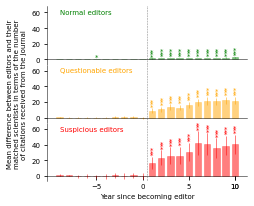

In [28]:
%%time
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(9*cm, 7*cm))
plt.rcParams.update({'font.size': 7})

spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, hspace=0)
axes = [fig.add_subplot(spec2[0, 0]), fig.add_subplot(spec2[1, 0]), fig.add_subplot(spec2[2, 0])]

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[1].set_ylabel("Mean difference between editors and their\nmatched scientists in terms of the number\n"+
                   r"of citations received from the journal")
axes[2].set_xticks([10, -5, 0, 5, 10])

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')

    ax.spines['top'].set_visible(False)
    ax.vlines(0.5, -20, 120, color='gray', linestyles='dashed', lw=0.5)

plotBars(citeG, axes, ylim=68)

axes[0].text(-9, 58, "Normal editors", c='green', ha='left')
axes[1].text(-9, 58, "Questionable editors", c='orange', ha='left')
axes[2].text(-9, 58, "Suspicious editors", c='red', ha='left')

axes[2].set_xlabel("Year since becoming editor")

plt.savefig("../figures/fig_2_e.pdf",bbox_inches = 'tight', pad_inches = 0)

# -0.03 0.01 -0.01 0.03 0.14 0.06 0.04 0.08 -0.03 0.0 	 0.97 1.19 1.47 1.54 1.59 1.72 1.83 1.88 2.01 2.29 
# 0.2 -0.09 -0.34 -0.36 -0.24 -0.08 0.29 0.59 0.53 0.0 	 8.68 10.6 13.21 12.73 16.2 19.5 21.38 20.57 21.85 21.53 
# 0.55 0.4 -0.53 -0.57 -0.44 -0.61 0.57 -0.44 0.97 -0.03 	 16.5 23.13 25.79 26.01 30.8 42.0 40.34 35.41 38.8 40.4 

0.01 0.01 0.01 0.0 0.02 0.01 0.01 0.01 -0.05 0.0 	 0.18 0.16 0.16 0.15 0.14 0.11 0.11 0.11 0.11 0.11 
0.01 -0.02 -0.01 -0.06 -0.05 0.04 0.05 0.04 0.03 0.0 	 1.52 1.44 1.97 1.76 1.67 2.17 2.04 1.79 1.83 1.78 
0.0 0.01 -0.03 -0.01 0.03 -0.0 -0.05 0.04 -0.03 0.0 	 2.35 2.46 3.59 3.53 3.24 4.43 4.35 3.53 3.58 3.12 
CPU times: user 710 ms, sys: 33.7 ms, total: 743 ms
Wall time: 815 ms


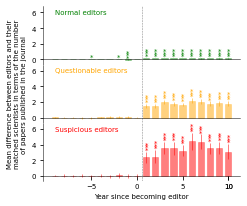

In [29]:
%%time
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(9*cm, 7*cm))
plt.rcParams.update({'font.size': 7})

spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, hspace=0)
axes = [fig.add_subplot(spec2[0, 0]), fig.add_subplot(spec2[1, 0]), fig.add_subplot(spec2[2, 0])]

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[1].set_ylabel("Mean difference between editors and their\nmatched scientists in terms of the number\n"+
                   "of papers published in the journal")
axes[2].set_xticks([10, -5, 0, 5, 10])

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_visible(False)
    ax.vlines(0.5, -20, 120, color='gray', linestyles='dashed', lw=0.5)

axes[0].text(-9, 5.8, "Normal editors", c='green', ha='left')
axes[1].text(-9, 5.8, "Questionable editors", c='orange', ha='left')
axes[2].text(-9, 5.8, "Suspicious editors", c='red', ha='left')


plotBars(pubG, axes, ylim=6.8)
axes[2].set_xlabel("Year since becoming editor")


plt.savefig("../figures/main_2_pub_match.pdf",bbox_inches = 'tight', pad_inches = 0)

# 0.01 0.01 0.01 0.0 0.02 0.01 0.01 0.01 -0.05 0.0 	 0.18 0.16 0.16 0.15 0.14 0.11 0.11 0.11 0.11 0.11 
# 0.01 -0.02 -0.01 -0.06 -0.05 0.04 0.05 0.04 0.03 0.0 	 1.52 1.44 1.97 1.76 1.67 2.17 2.04 1.79 1.83 1.78 
# 0.0 0.01 -0.03 -0.01 0.03 -0.0 -0.05 0.04 -0.03 0.0 	 2.35 2.46 3.59 3.53 3.24 4.43 4.35 3.53 3.58 3.12 